# Исходные данные

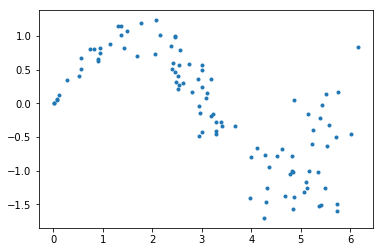

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = 100
x = np.random.uniform(0, 2 * np.pi, size=N)
y = np.zeros(N, np.float64)
for i in range(N):
    y[i] = np.sin(x[i]) + np.random.normal(scale=0.01 + 0.1 * x[i])

plt.plot(x, y, '.')
plt.show()

# Ядерная регрессия

## Регрессия по формуле Надарая-Ватсона

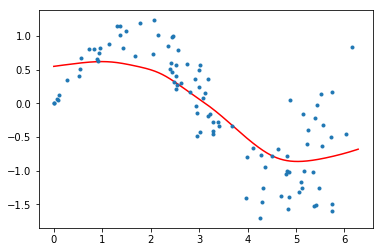

In [2]:
from scipy.stats import gaussian_kde, norm

L = 10 ** 4
z = np.linspace(0, 2 * np.pi, num=L)

kde = gaussian_kde(y)
y_nw = np.zeros(L, np.float64)
for i in range(L):
    y_nw[i] = (kde(z[i] - x) * y).sum() / kde(z[i] - x).sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y_nw, '-', color='red')
ax.plot(x, y, '.')
plt.show()

### Более простой способ

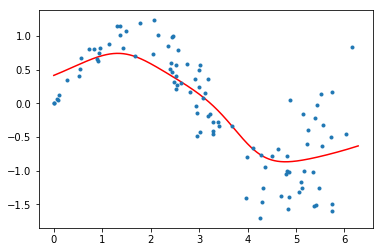

In [3]:
from kernel_regression import KernelRegression

z = np.linspace(0, 2 * np.pi, num=L)

kr = KernelRegression()
kr.fit(x.reshape(-1, 1), y)
y_kr = kr.predict(z.reshape(-1, 1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y_kr, '-', color='red')
ax.plot(x, y, '.')
plt.show()

## Доверительные интервалы

### Гомоскедастичность

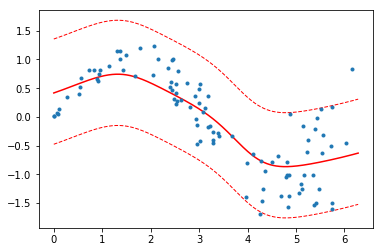

In [4]:
e = y - kr.predict(x.reshape(-1, 1))  # оценки ошибок регрессии
s2 = e.var()  # оценка дисперсии ошибок 
g = (4 / (3 * N)) ** (1/5) * np.sqrt(s2)  # сглаживающий множитель

# бутстрап
b = 10 ** 4
e_star = np.sort(np.random.choice(e, size=b, replace=True) + g * np.random.normal(size=b))

# доверительные интервалы
alpha = 0.95  # уровень значимости
q_left = e_star[round((1 - alpha) / 2 * b)]  # левый квантиль ошибок
q_right = e_star[round((1 + alpha) / 2 * b)]  # правый квантиль ошибок
lower_bound = y_kr + q_left  # нижняя граница доверительного интервала
upper_bound = y_kr + q_right  # верхняя граница доверительного интервала

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y_kr, '-', color='red')
ax.plot(z, lower_bound, '--', color='red', linewidth=1)
ax.plot(z, upper_bound, '--', color='red', linewidth=1)
ax.plot(x, y, '.')
plt.show()

### Гетероскедастичность

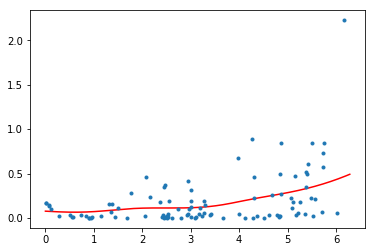

In [5]:
s2 = (e - e.mean()) ** 2  # оценки условной дисперсии остатков

# зависимость условной дисперсии от экзогенных переменных
s_model = KernelRegression()
s_model.fit(x.reshape(-1, 1), s2)
s2_hat = s_model.predict(z.reshape(-1, 1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, s2_hat, '-', color='red')
ax.plot(x, s2, '.')
plt.show()

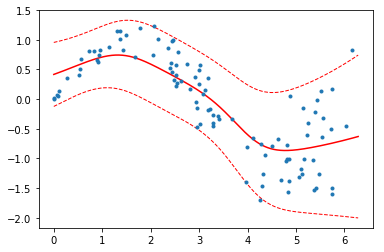

In [6]:
from scipy.stats import norm

s_hat = s2_hat ** 0.5

# доверительный интервал
alpha = 0.95
q_left = np.zeros(L, np.float64)
q_right = np.zeros(L, np.float64)
for i in range(L):
    q_left[i] = norm.ppf((1 - alpha) / 2, loc=0, scale=s_hat[i])
    q_right[i] = norm.ppf((1 + alpha) / 2, loc=0, scale=s_hat[i])
lower_bound = y_kr + q_left
upper_bound = y_kr + q_right

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y_kr, '-', color='red')
ax.plot(z, lower_bound, '--', color='red', linewidth=1)
ax.plot(z, upper_bound, '--', color='red', linewidth=1)
ax.plot(x, y, '.')
plt.show()

# Гауссовский процесс

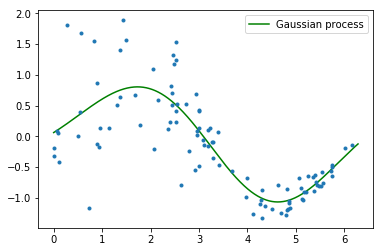

In [7]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor


for i in range(N):
#     y[i] = np.sin(x[i]) + np.random.normal(scale=0.01 + 0.1 * x[i])
    y[i] = np.sin(x[i]) + np.random.normal(scale=0.8 - 0.125 * x[i])
    
z = np.linspace(0, 2 * np.pi, num=L)

kern = RBF() + WhiteKernel() * DotProduct()
gpr = GaussianProcessRegressor(kernel=kern)
gpr.fit(x.reshape(-1, 1), y)
y_gpr = gpr.predict(z.reshape(-1, 1))

# y_kr = kr.predict(z.reshape(-1, 1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y_gpr, '-', color='green', label='Gaussian process')
# ax.plot(z, y_kr, '--', color='red', linewidth=1, label='Kernel regression')
ax.plot(x, y, '.')
plt.legend()
plt.show()

## Доверительный интервал

В каждой точке мы можем сгенерировать множество случайных реализаций оцененного гауссовского процесса и найти в этом множестве эмпирические квантили, которые будут служить границами доверительного интервала

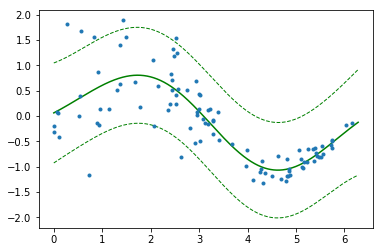

In [8]:
b = 10 ** 4
alpha = 0.95

lower_bound = np.zeros(L, np.float64)
upper_bound = np.zeros(L, np.float64)
    
for i in range(L):
    samples = np.sort(gpr.sample_y([[z[i]]], n_samples=b).flatten())
    lower_bound[i] = samples[round((1 - alpha) / 2 * b)]
    upper_bound[i] = samples[round((1 + alpha) / 2 * b)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y_gpr, '-', color='green')
ax.plot(z, lower_bound, '--', color='green', linewidth=1)
ax.plot(z, upper_bound, '--', color='green', linewidth=1)
ax.plot(x, y, '.')
plt.show()